In [1]:
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet

from pandas_datareader import data as pdr
import yfinance as yfin

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import mlflow
import os 

yfin.pdr_override()

In [2]:
# MLFLOW_IP = os.environ['MLFLOW_IP']
# MLFLOW_PASSWORD = os.environ['MLFLOW_PASSWORD']
# MLFLOW_USER = os.environ['MLFLOW_USER']
# MLFLOW_PORT = os.environ['MLFLOW_PORT']

In [4]:
mlflow.set_tracking_uri('http://{}:{}'.format(MLFLOW_IP, MLFLOW_PORT))

In [5]:
# exp_id = mlflow.create_experiment(
#     name='Prophet',
#     artifact_location="sftp://{}:{}@{}:/home/godder/mlflow_storage/artifacts".format(MLFLOW_USER, MLFLOW_PASSWORD, MLFLOW_IP),
#     tags={'ticker':'^GSPC'}
# )

In [6]:
exp_id = mlflow.get_experiment_by_name('Prophet').experiment_id

mlflow.set_experiment(experiment_id=exp_id)
print('done')

done


In [7]:
ticker_name = 'AAPL'

In [8]:
mlflow.start_run(experiment_id=exp_id, run_name='Prophet training')

<ActiveRun: >

In [9]:
mlflow.set_tag('ticker', ticker_name)

17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 7 days which is larger than initial window. Consider increasing initial.
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] done processing
17:41:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:10 - cmdstanpy - INFO - Chain [1] done processing
17:41:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization term

    changepoint_prior_scale  seasonality_prior_scale  weekly_seasonality  \
0                     0.001                     0.01                True   
1                     0.001                     0.01               False   
2                     0.001                     0.10                True   
3                     0.001                     0.10               False   
4                     0.001                     1.00                True   
5                     0.001                     1.00               False   
6                     0.001                    10.00                True   
7                     0.001                    10.00               False   
8                     0.010                     0.01                True   
9                     0.010                     0.01               False   
10                    0.010                     0.10                True   
11                    0.010                     0.10               False   
12          

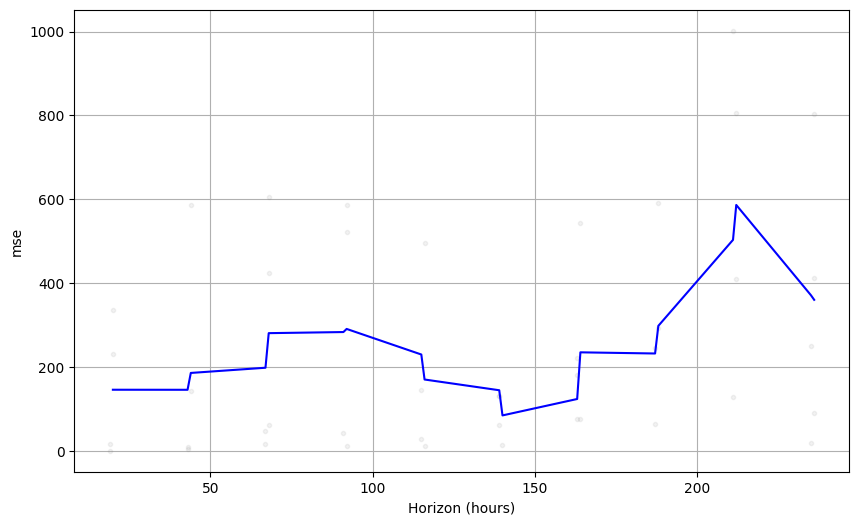

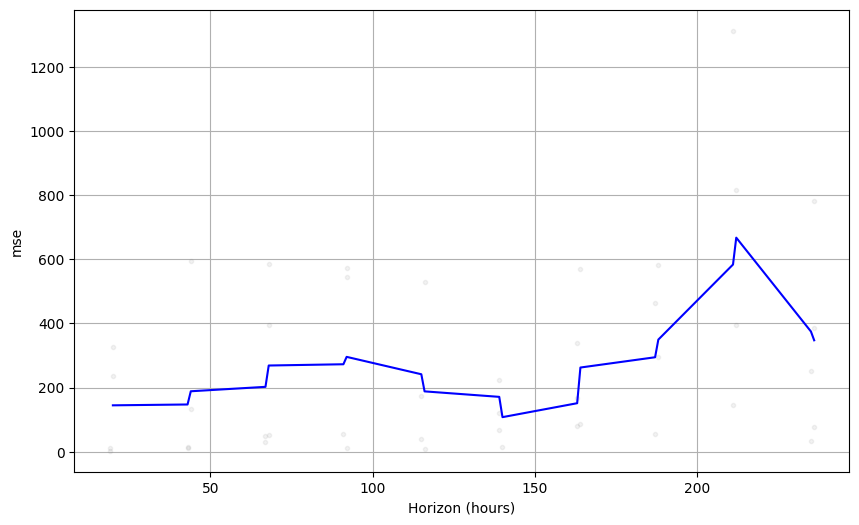

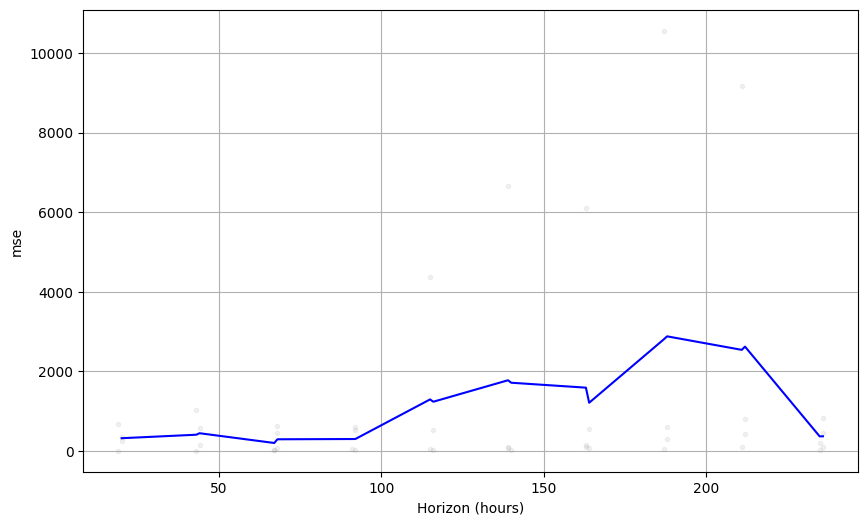

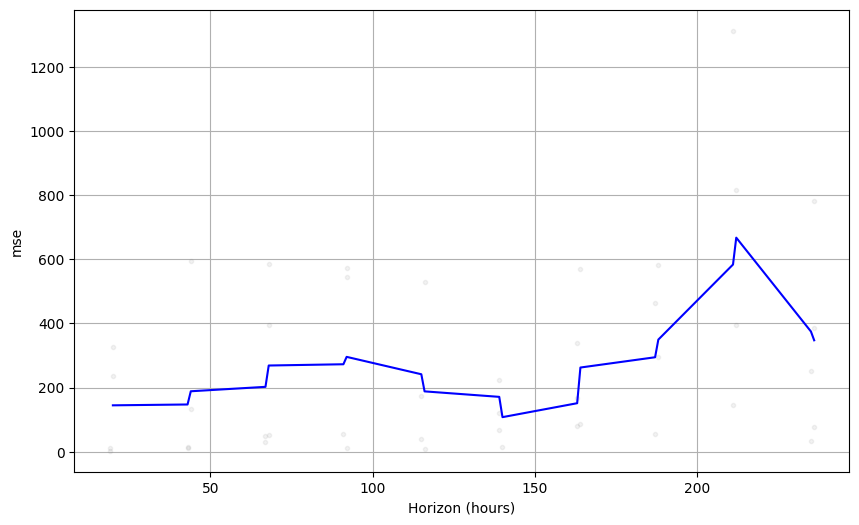

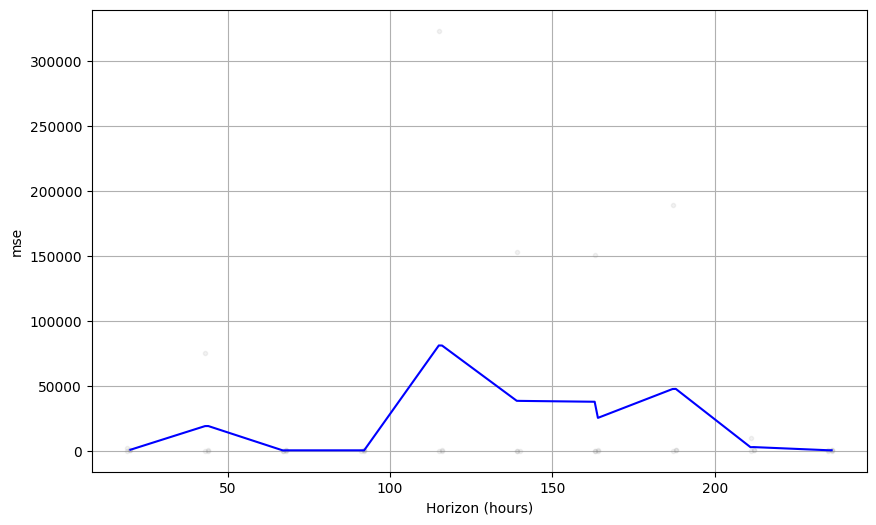

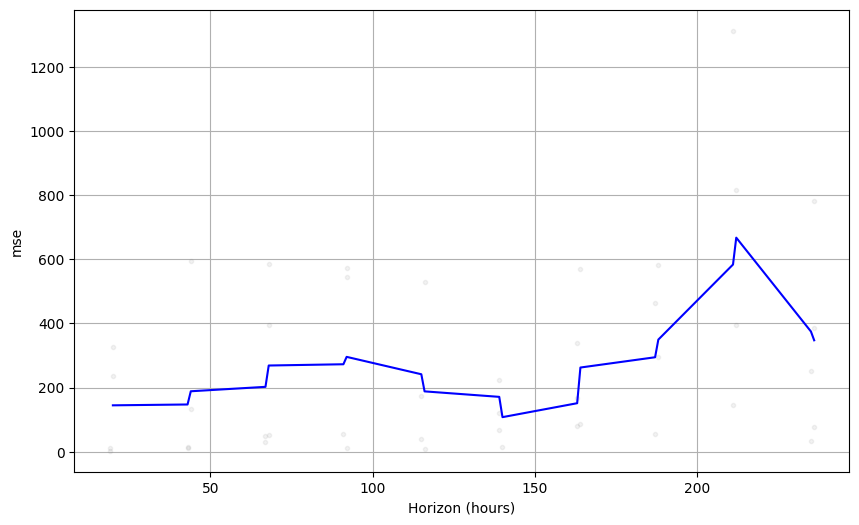

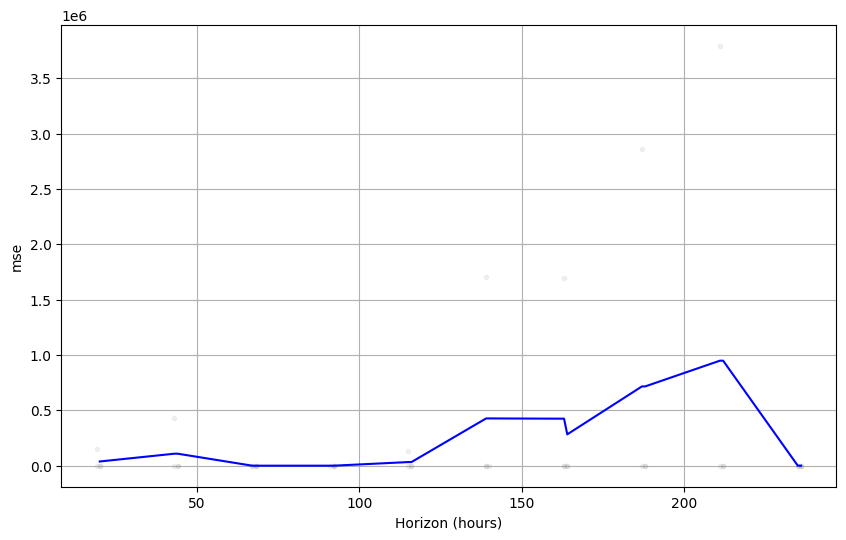

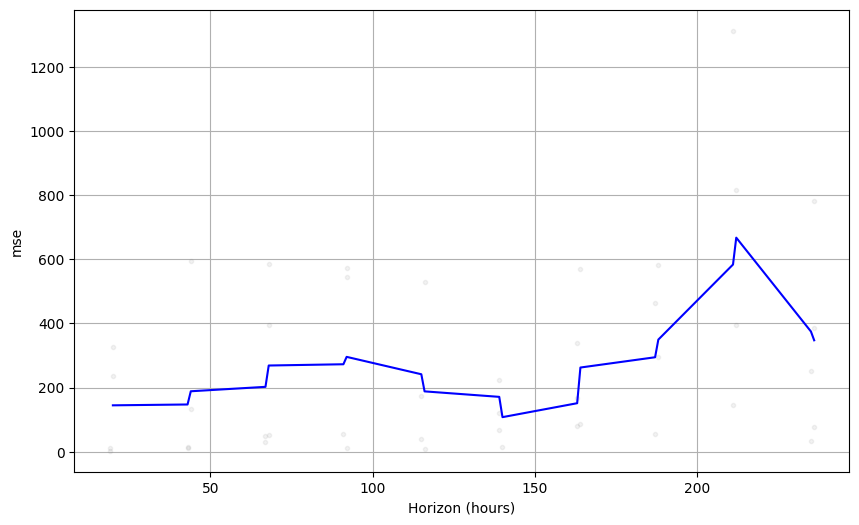

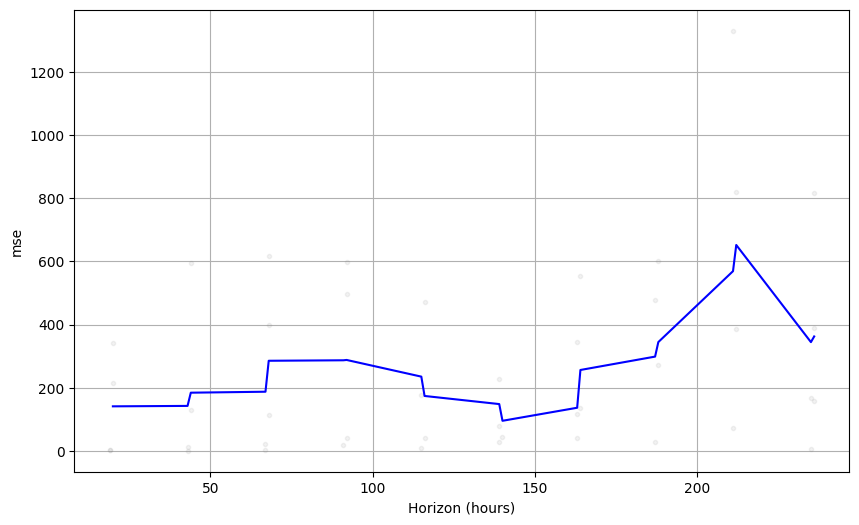

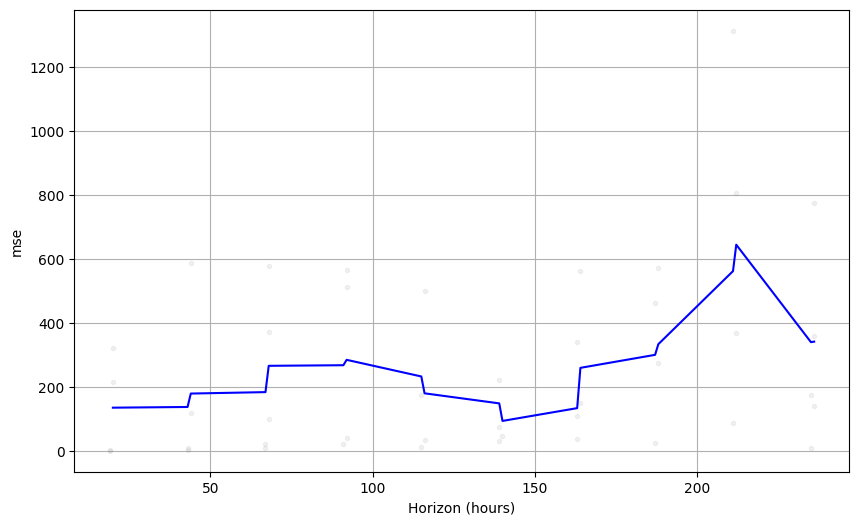

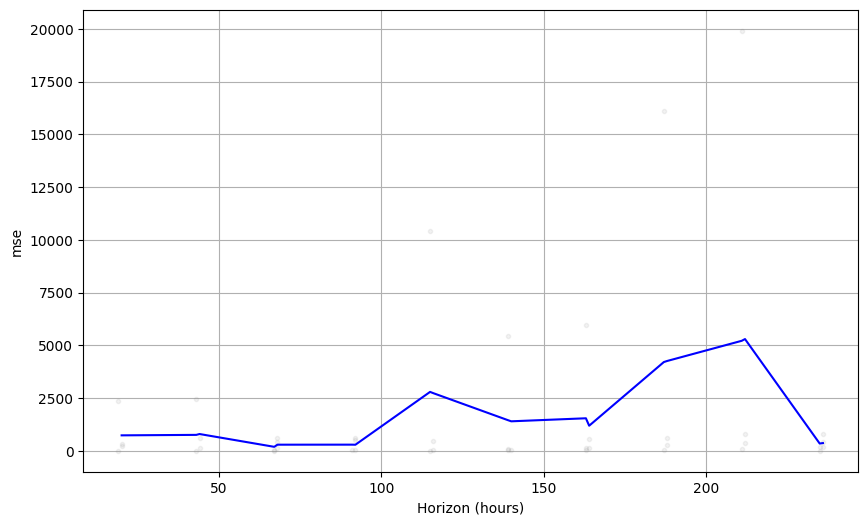

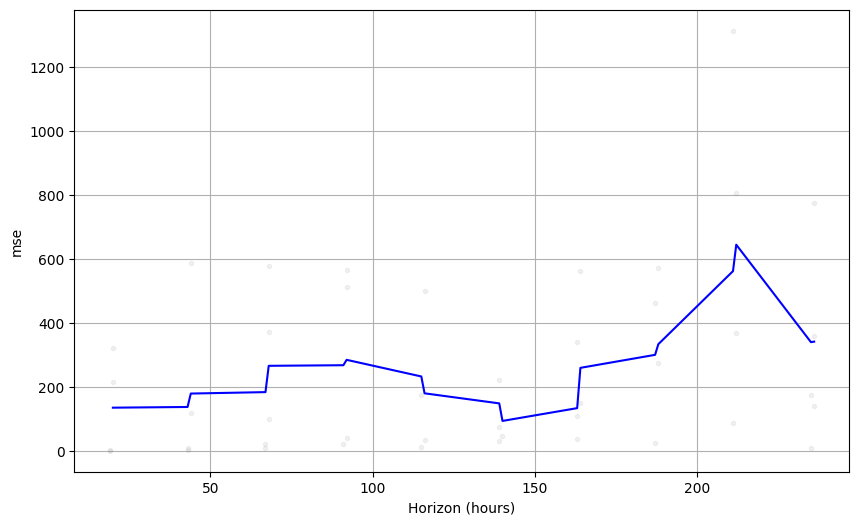

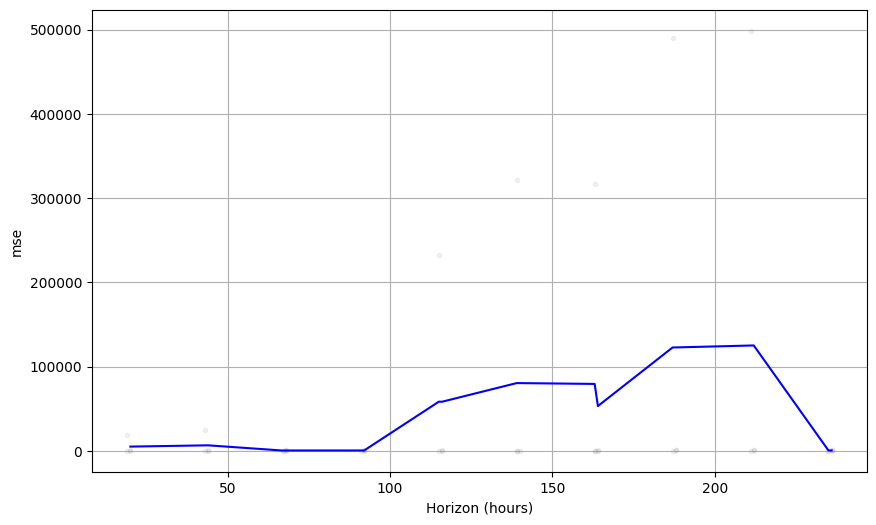

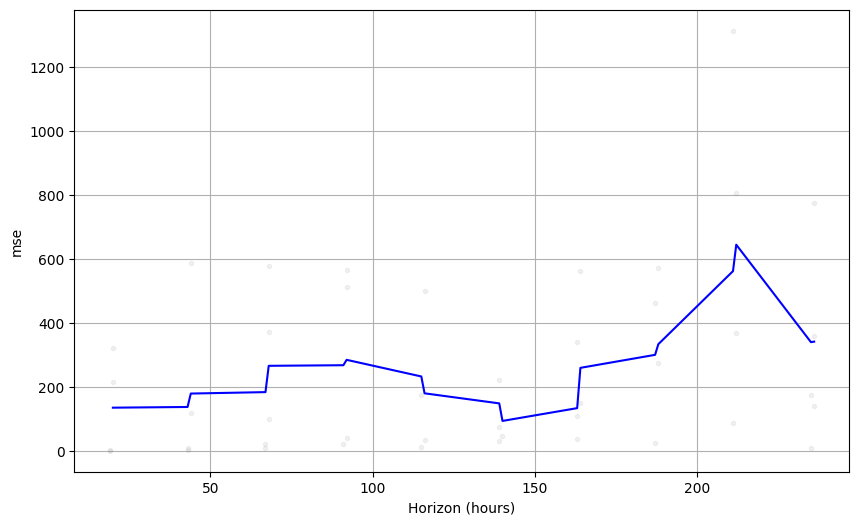

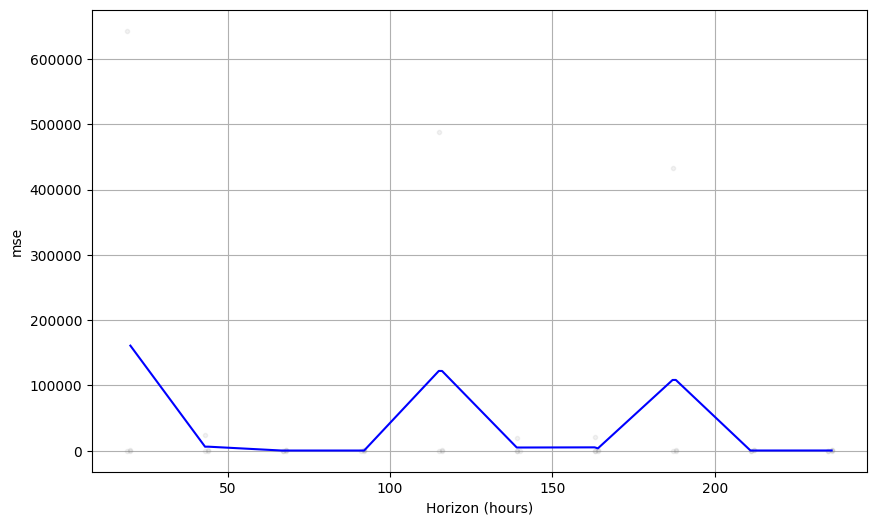

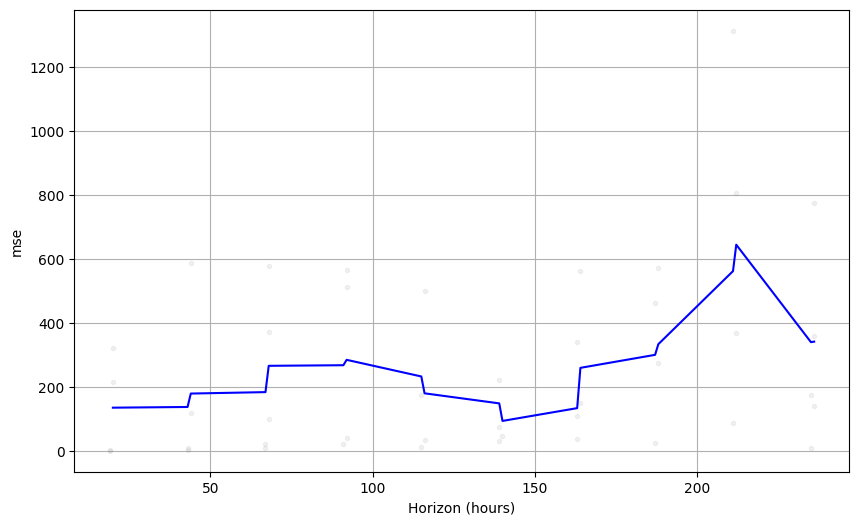

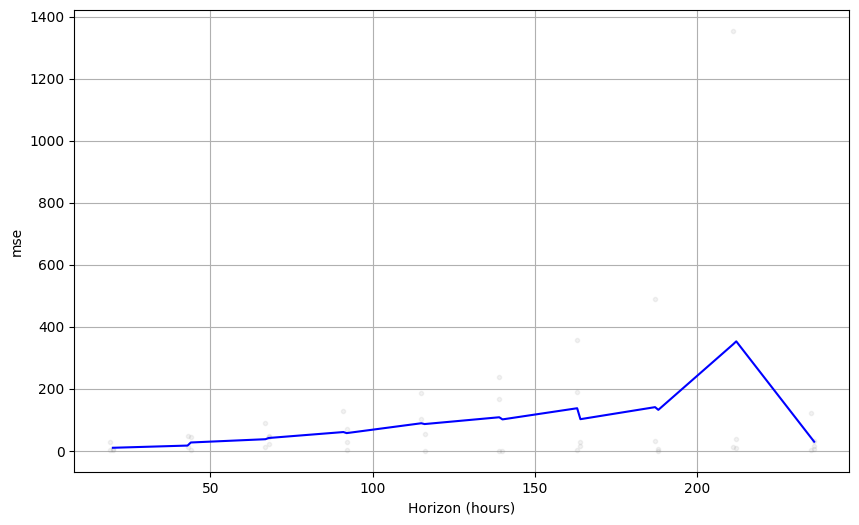

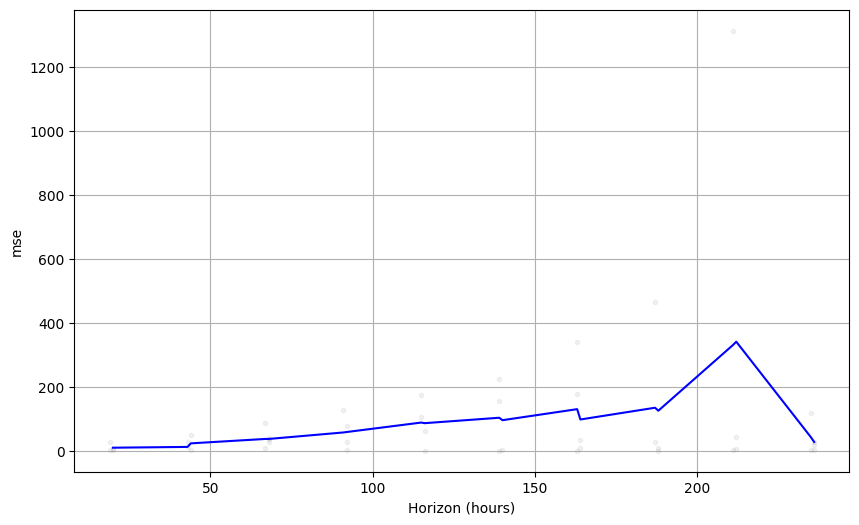

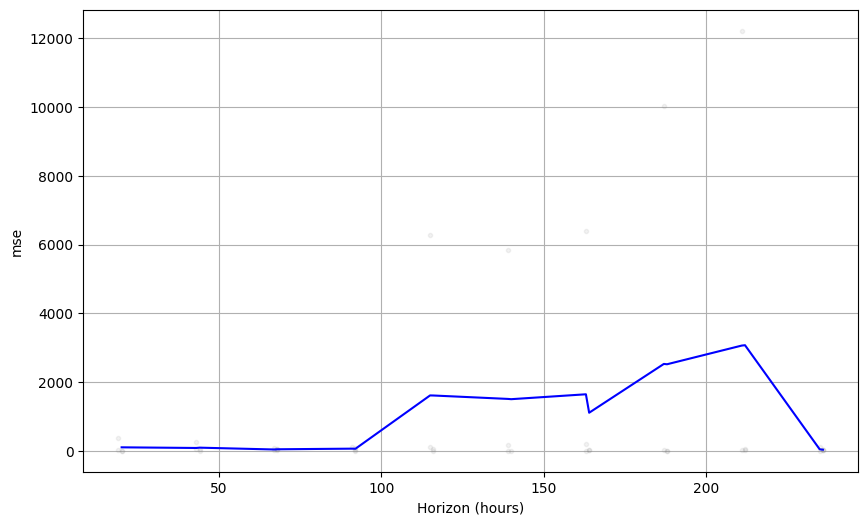

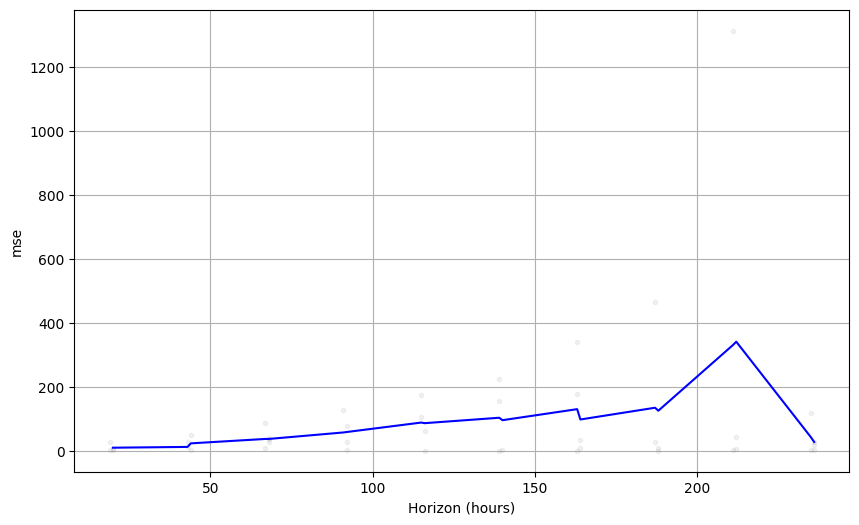

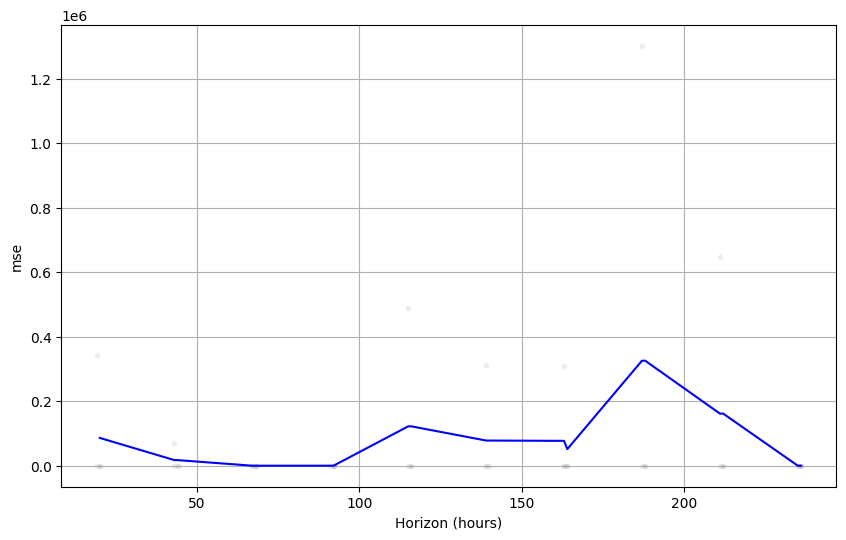

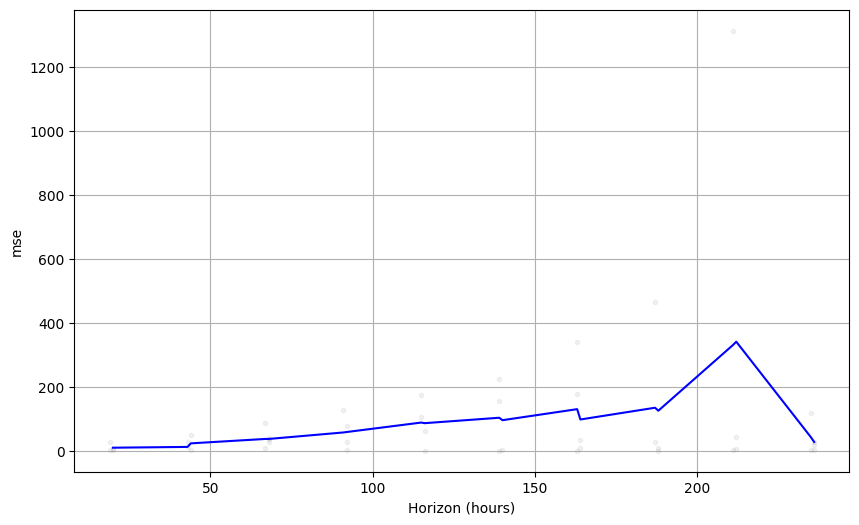

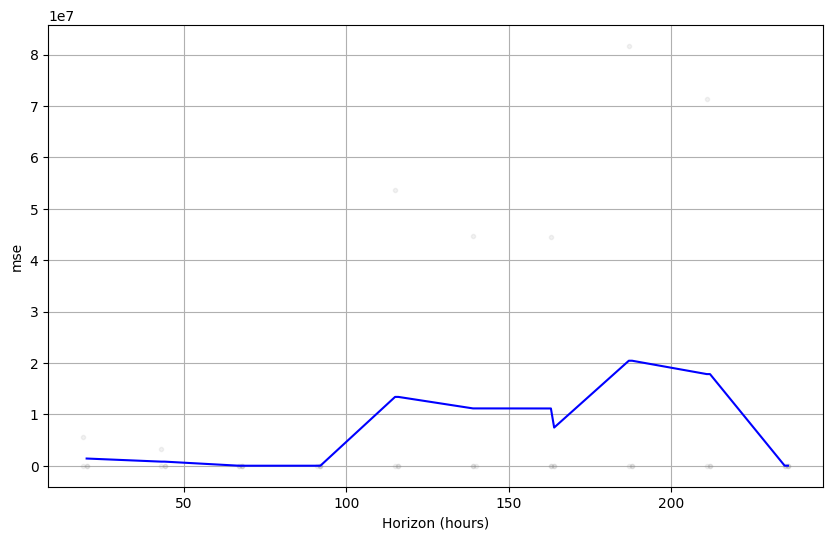

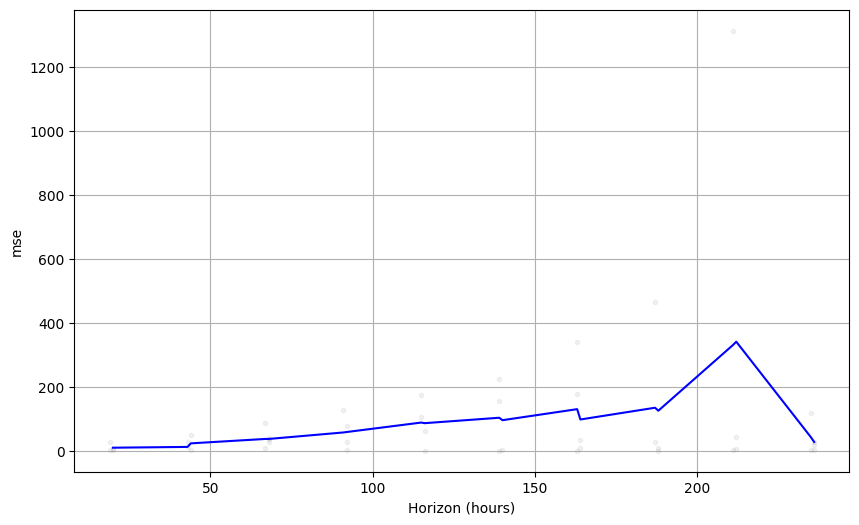

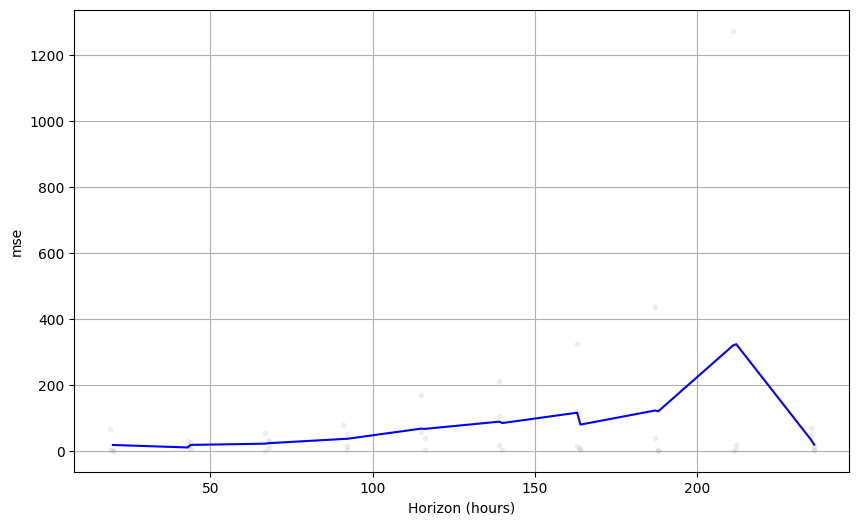

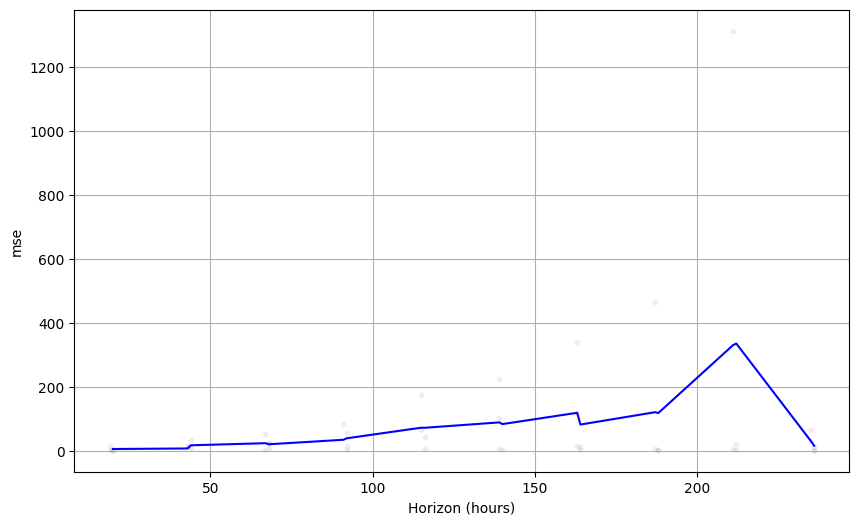

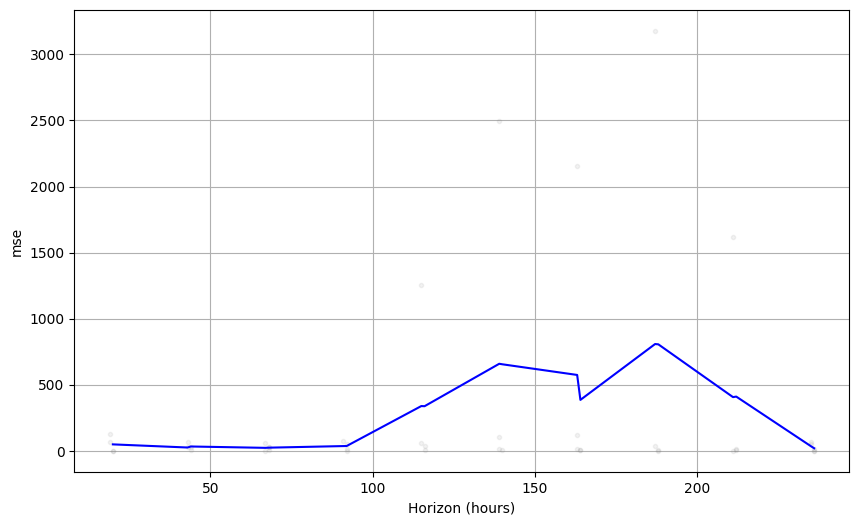

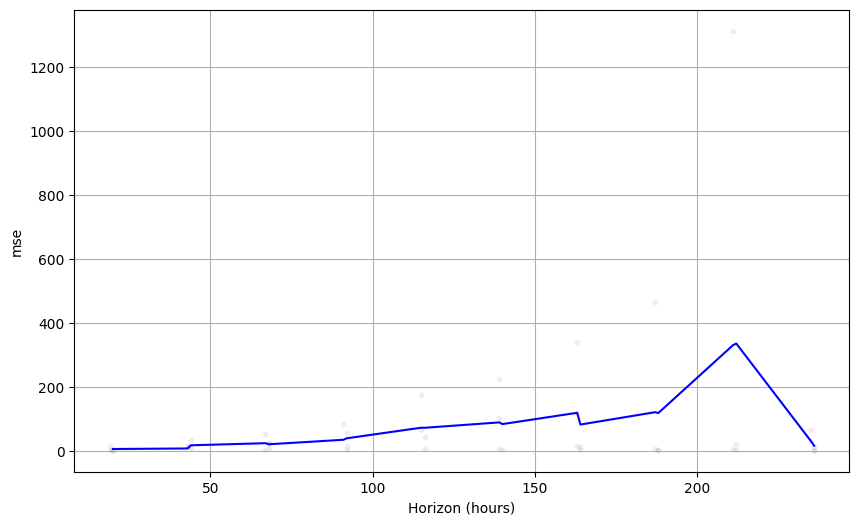

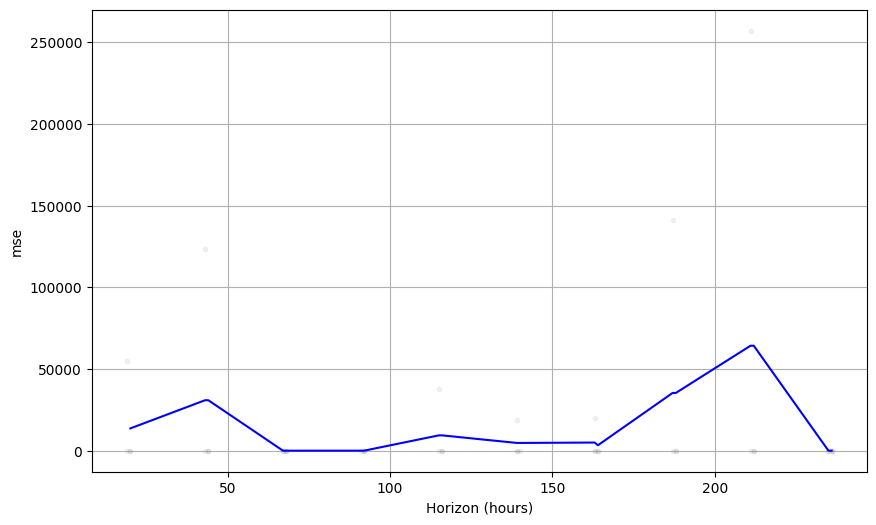

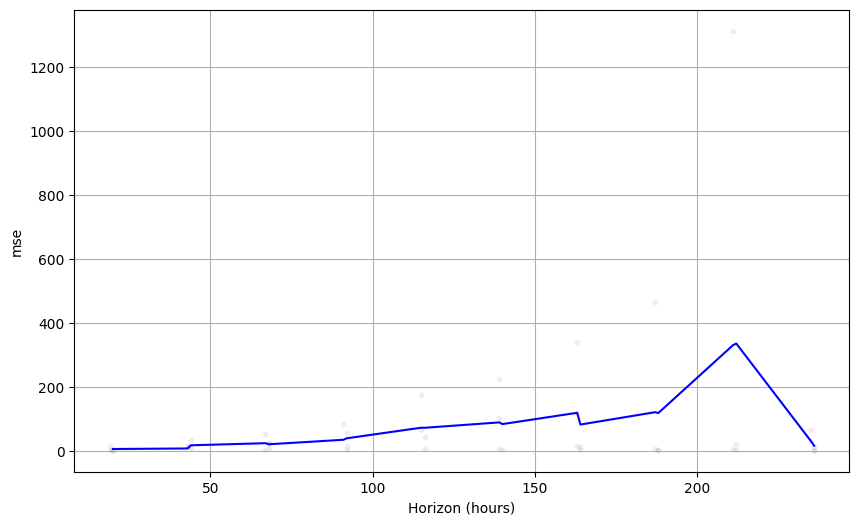

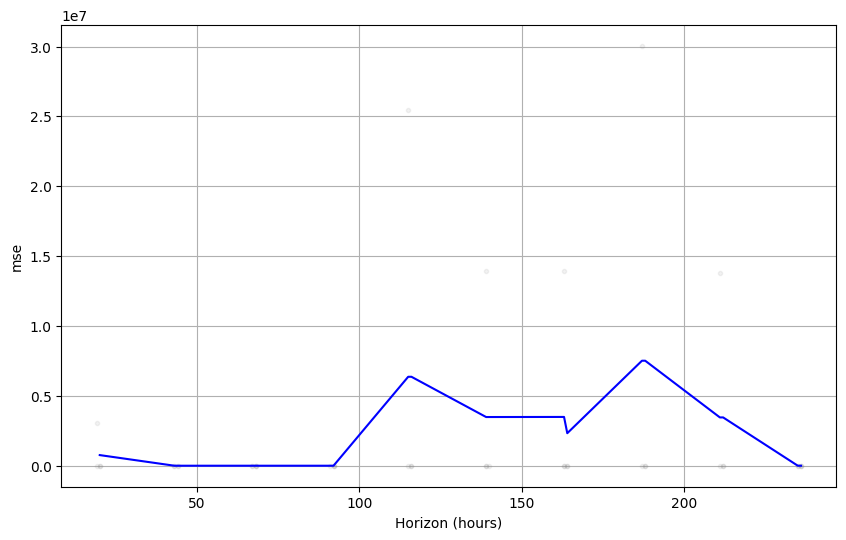

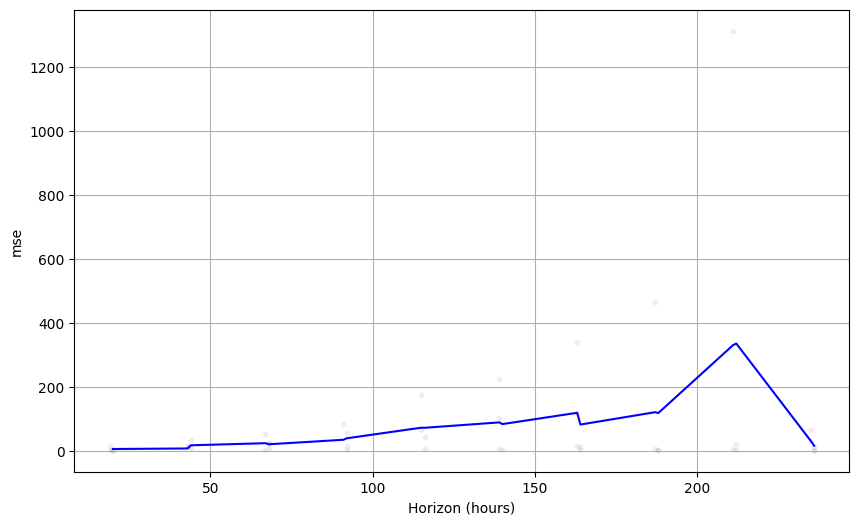

In [10]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'weekly_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here
mses = [] # Store the MSEs for each params here
# mapes = [] # Store the RMSEs for each params here
# maes = [] # Store the RMSEs for each params here
figs = {}

train_df = pd.read_csv(f'/home/godder/data/NASDAQ_100/{ticker_name}.csv')
train_df = train_df[['Date', 'Close']]
train_df.rename({'Date': 'ds', 'Close': 'y'}, axis=1, inplace=True)

# Use cross validation to evaluate all parameters
i = 0
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    cutoffs = pd.to_datetime(['2022-01-19', '2022-03-01', '2022-05-15', '2022-08-01', '2022-09-30', '2022-11-11'])
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    # rmses.append(df_p['rmse'].values[0])
    mses.append(df_p['mse'].values[0])
    figs[i] = plot_cross_validation_metric(df_cv, metric='mse')
    mlflow.log_metric('MSE/test', df_p['mse'].values[0], step=i)
    i+=1
    # mapes.append(df_p['mape'].values[0])
    # maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mses
print(tuning_results)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False} 78.5397259406637


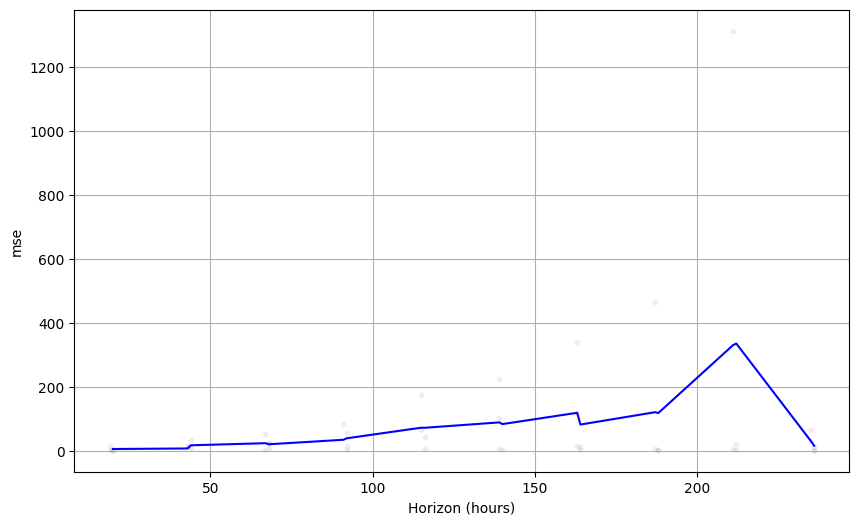

In [11]:
idx = np.argmin(mses)
best_params = all_params[idx]
best_metric = np.min(mses)
print(best_params, best_metric)
figs[idx]

In [12]:
mlflow.log_param('seasonality_prior_scale', best_params['seasonality_prior_scale'])
mlflow.log_param('changepoint_prior_scale', best_params['changepoint_prior_scale'])
mlflow.log_param('weekly_seasonality', best_params['weekly_seasonality'])

False

In [13]:
mlflow.log_figure(figs[idx], 'test_plot.png')

In [14]:
# mlflow.log_metric('MSE/test', best_metric)

In [15]:
days=10

In [16]:
m = Prophet(**best_params).fit(train_df)

17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = m.make_future_dataframe(periods=days)
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

In [18]:
forecast = m.predict(future)

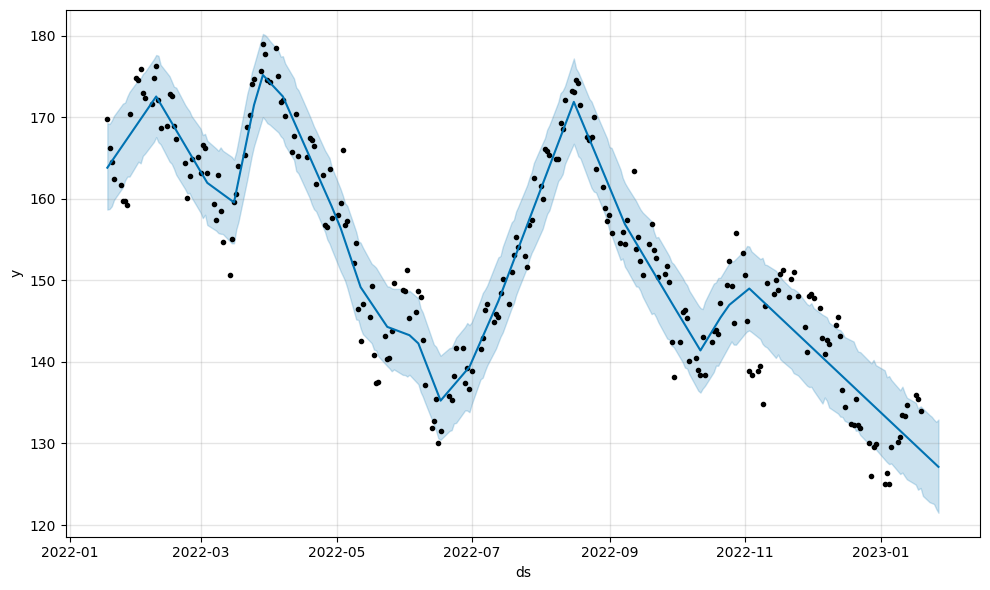

In [19]:
fig1 = m.plot(forecast)

In [20]:
signature = mlflow.models.signature.infer_signature(future)

/usr/local/lib/python3.8/dist-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [21]:
mlflow.prophet.log_model(m,
                         'prophet',
                         registered_model_name='Prophet',
                         signature=signature,
                         input_example=future)

Registered model 'Prophet' already exists. Creating a new version of this model...
2023/01/19 17:41:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Prophet, version 9
Created version '9' of model 'Prophet'.


In [22]:
mlflow.end_run()

# Fetching and testing

In [28]:
model = mlflow.prophet.load_model(
    model_uri=f"models:/Prophet/9"
)

/usr/local/lib/python3.8/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [29]:
preds = model.predict(future)

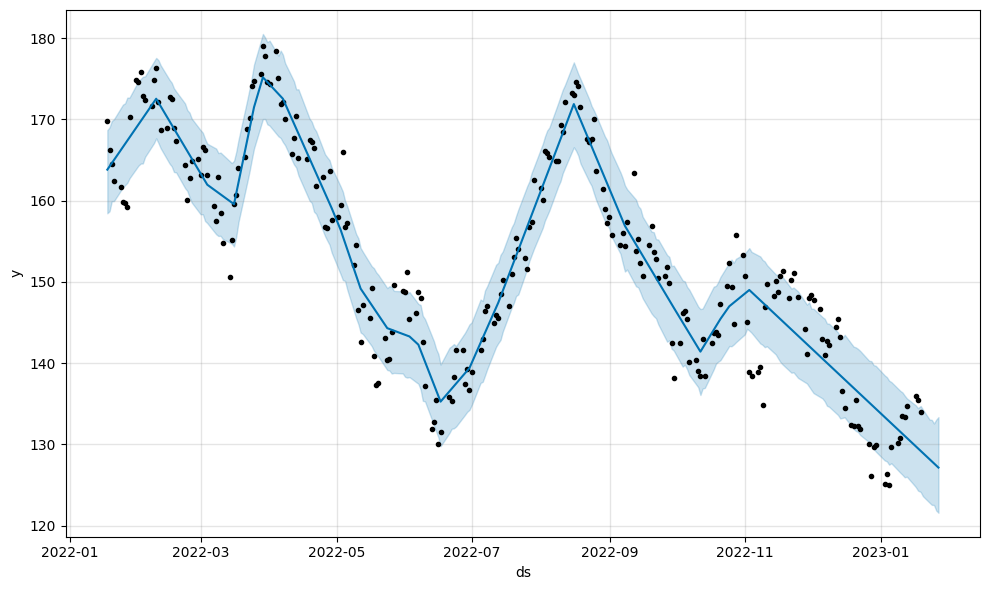

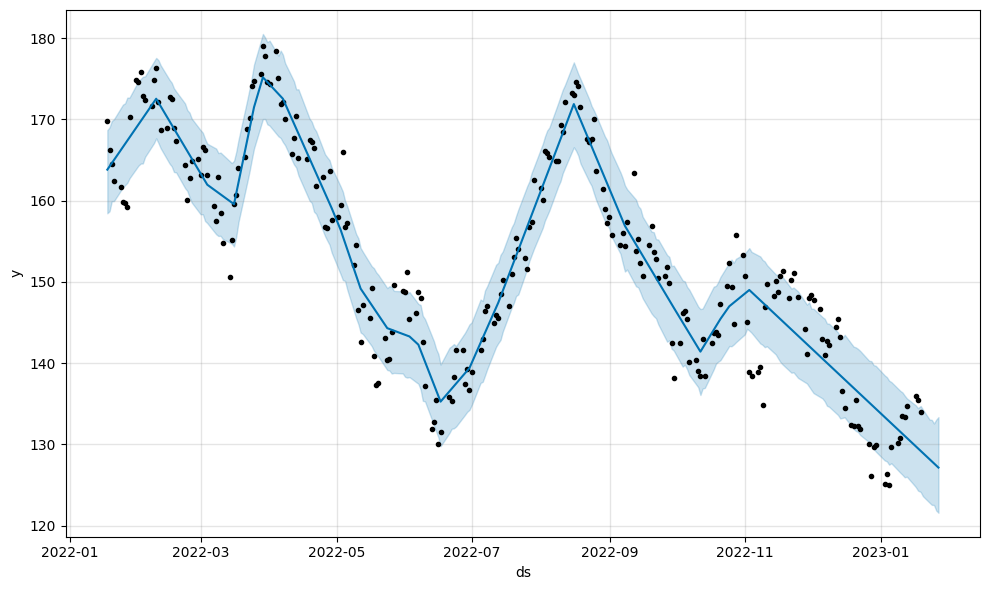

In [30]:
model.plot(preds)

done checking... changing stage to "Staging"

In [25]:
tracking_uri = mlflow.get_tracking_uri()
registry_uri = mlflow.get_registry_uri()

client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)

client.transition_model_version_stage(
    name="Prophet",
    version=7,
    stage="Staging"
)

client.transition_model_version_stage(
    name="Prophet",
    version=6,
    stage="Archived"
)
print('done')

done
